# Use SKlearn and Amazon SageMaker Clarify
_**Run Amazon SageMaker Clarify processing after you trained a model**_

---

Take introduction from here:

https://github.com/aws/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/linear_learner_abalone/Linear_Learner_Regression_csv_format.ipynb

## Contents
1. [Introduction](#Introduction)
2. [Setup](#Setup)
  1. [Source the libraries](#Source-the-libraries)
  2. [Set S3 bucket and data prefix](#Set-S3-bucket-and-data-prefix)
  3. [Set role and global vars](#Set-role-and-global-vars)
3. [Load the data](#Load-the-data)
4. [Upload the data to S3](#Upload-the-data-to-S3)
5. [Train a SKLearn estimator](#Train-a-SKLearn-estimator)
6. [Amazon SageMaker Clarify](#Amazon-SageMaker-Clarify)

---

## Introduction

This notebook demonstrates the use of Amazon SageMaker SKLearn to train a regression model. 

We use the [Abalone data](https://datahub.io/machine-learning/abalone), originally from the [UCI data repository](https://archive.ics.uci.edu/ml/datasets/abalone). More details about the original dataset can be found [here](https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.names).

---
## Setup

This notebook was tested in Amazon SageMaker notebook on a ml.t3.medium instance with Python 3 (conda_python3) kernel.

Let's start by specifying:
1. Sourcing libraries
2. The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
3. The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).
4. The global variables used later for training the model

### Source the libraries

In [1]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.sklearn.estimator import SKLearn
import pandas as pd
import numpy as np
import urllib
import boto3
import json
import os
import time
import matplotlib.pyplot as plt

### Set S3 bucket and data prefix

In [2]:
# Provide information to where the training and validation data will be uploaded to 
S3_BUCKET = 'sagemaker-clarify-demo' # YOUR_S3_BUCKET
PREFIX = 'abalone-clarify-notebook'
DATA_PREFIX = f'{PREFIX}/prepared_data'

### Set role and global vars

In [3]:
# Get a SageMaker-compatible role used by this function and the session.
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
role = get_execution_role()

# Set your instance count and type
framework_version = '0.23-1'
instance_type = 'ml.m5.xlarge'
instance_count = 1

# Set your code folder
source_dir = 'model/'
entry_point = 'predictor.py'

## Load the data

Read the dataset from your raw input prefix within S3

In [4]:
df = pd.read_csv('https://datahub.io/machine-learning/abalone/r/abalone.csv')
cols = [x if "rings" not in x else "Rings" for x in df.columns]
df.columns = cols

In [5]:
df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Define the target column of the data set for later referencing, also within Clarify

In [6]:
target_col = 'Rings'

In [7]:
# X: input features - this is what your algorithm takes for learning
# y: target - this is what your algorithm will predict
X = df.drop(target_col, axis=1)
y = df[target_col]

Use the train_test_split function to split your data. Don't forget to set a random_state to ensure reproduceability!

In [8]:
from sklearn.model_selection import train_test_split
# Split the data into 70% training and 30% validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

SageMaker algorithms and features require the target column to come in first place

In [9]:
train = pd.concat([y_train, X_train], axis=1)
val = pd.concat([y_val, X_val], axis=1)

## Upload the data to S3
The data must lie in S3 to make it consumable by the SKLearn container and Clarify.

Save your data locally first: training, validation and the features of the validation set for Clarify

In [15]:
train.to_csv('train_data.csv', index=False) # training data
val.to_csv('val_data.csv', index=False) # validation data
baseline = train.agg({'Sex': 'mode', 
                      'Length': 'mean', 
                      'Length': 'mean', 
                      'Diameter': 'mean', 
                      'Height': 'mean', 
                      'Whole_weight': 'mean', 
                      'Shucked_weight': 'mean', 
                      'Viscera_weight': 'mean', 
                      'Shell_weight': 'mean'}) # used in SageMaker Clarify: only store your features
baseline.to_csv('baseline.csv', index=False, header=None)

In [22]:
# write the columns to be one hot encoded and the column names, in the same order as in the training data into a config file
# this config file will be read during training and prediction to one hot encode the columns 
config_data = {
    'one_hot_encoding': ['Sex'], 
    'numeric': ['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight'],
    'header': train.columns.tolist()
}
with open('config_data.json', 'w') as outfile:
    json.dump(config_data, outfile)

Upload the data to S3 so it can be consumed by SageMaker training job and Clarify

In [23]:
from sagemaker.s3 import S3Uploader
from sagemaker.inputs import TrainingInput
train_uri = S3Uploader.upload('train_data.csv', f's3://{S3_BUCKET}/{DATA_PREFIX}')
val_uri = S3Uploader.upload('val_data.csv', f's3://{S3_BUCKET}/{DATA_PREFIX}')
baseline_uri = S3Uploader.upload('baseline.csv', f's3://{S3_BUCKET}/{DATA_PREFIX}')
config_uri = S3Uploader.upload('config_data.json', f's3://{S3_BUCKET}/{DATA_PREFIX}')

In [24]:
# Set training input for the SKlearn estimator (not necessary but recommended)
train_data = TrainingInput(train_uri, content_type='csv')
validation_data = TrainingInput(val_uri, content_type='csv')
config_data = TrainingInput(config_uri, content_type='json')

## Train a SKLearn estimator

Define an estimator to create a model upon which clarify provides explainability. This could be any estimator from the builtin algorithms (https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html) or a Base Estimator like Sklearn or similar. 

The model class can be either classifiction or regression. 

As an example the following uses the SKLearn Base estimator to train a RandomForestRegressor on the underlying data. Please see the file model/predictor.py for a definition of the SKLearn Base estimator which will be used in the following.

For more info regarding the SKLearn container please visit: https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html#scikit-learn-estimator

In [25]:
# Set the hyperparamters for this RandomForestRegressor. In this simple example only 3 Hyperparamters are permitted
hyperparameters = {
    'n_estimators': 100,
    'max_depth': 10,
    'max_features': 'sqrt',
    'random_state': 42
    }
sklearn = SKLearn(
    entry_point=entry_point,
    source_dir=source_dir,
    hyperparameters=hyperparameters,
    role=role,
    instance_count=instance_count,
    instance_type=instance_type,
    framework_version=framework_version,
    sagemaker_session=sagemaker_session,
    #code_location=f's3://{S3_BUCKET}/{PREFIX}/model/',
    output_path=f's3://{S3_BUCKET}/{PREFIX}/model/',
    enable_sagemaker_metrics=True,
    metric_definitions=[
        {
            'Name': 'train:mae',
            'Regex': 'Train_mae=(.*?);'
        },
        {
            'Name': 'validation:mae',
            'Regex': 'Validation_mae=(.*?);'
        }
    ])

In [26]:
# Train the model
sklearn.fit({
    'train': train_data,
    'validation': validation_data,
    'config': config_data}, wait=True)

2021-05-06 16:46:00 Starting - Starting the training job...
2021-05-06 16:46:24 Starting - Launching requested ML instancesProfilerReport-1620319560: InProgress
......
2021-05-06 16:47:24 Starting - Preparing the instances for training......
2021-05-06 16:48:25 Downloading - Downloading input data
2021-05-06 16:48:25 Training - Downloading the training image.....2021-05-06 16:49:12,230 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2021-05-06 16:49:12,233 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-05-06 16:49:12,248 sagemaker_sklearn_container.training INFO     Invoking user training script.
2021-05-06 16:49:12,546 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-05-06 16:49:13,167 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-05-06 16:49:13,178 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus install

### Create a SageMaker model for Amazon SageMaker Clarify
Create an SageMaker model from the SKLearn estimator

In [27]:
from time import gmtime, strftime

# generate time stamp
uid = strftime('%Y-%m-%d-%H-%M-%S', gmtime())

# Create model with model name
model_name = 'sagemaker-sklearn-clarify-{}'.format(uid)
model = sklearn.create_model(name=model_name)
container_def = model.prepare_container_def()
sagemaker_session.create_model(model.name, role, container_def)

'sagemaker-sklearn-clarify-2021-05-06-17-33-47'

## Amazon SageMaker Clarify
Apply Clarify on the trained SKLearn model and run explainability on the model

The next section is taken from

https://sagemaker-examples.readthedocs.io/en/latest/sagemaker_processing/fairness_and_explainability/fairness_and_explainability.html

and modified to this use case.

The following steps are necessary to explain predictions:
1. Create a Clarify Processor which will generate the explanations
1. Configure the Processor with the input data, where to store the output and detailed information about the dataset columns
1. Configure the Processor with the model to explain predictions for
1. Configure the Processor to use the SHAP value to explain predictions. Configure the SHAP value computation.
1. Explain the Predictions

In [28]:
from sagemaker import clarify
clarify_processor = clarify.SageMakerClarifyProcessor(role=role,
                                                      instance_count=1,
                                                      instance_type='ml.m5.xlarge',
                                                      sagemaker_session=sagemaker_session)

A `DataConfig` object communicates some basic information about data I/O to SageMaker Clarify. We specify where to find the input dataset, where to store the output, the target column (label), the header names, and the dataset type.

In [29]:
explainability_output_path = f's3://{S3_BUCKET}/{PREFIX}/clarify-explainability'
explainability_data_config = clarify.DataConfig(s3_data_input_path=train_uri,
                                s3_output_path=explainability_output_path,
                                label=target_col, # our target column
                                headers=train.columns.tolist(), # the columns of the training DataFrame
                                dataset_type='text/csv')

A `ModelConfig` object communicates information about your trained model. To avoid additional traffic to your production models, SageMaker Clarify sets up and tears down a dedicated endpoint when processing.

`accept_type` denotes the endpoint response payload format, and `content_type` denotes the payload format of request to the endpoint.

In [30]:
model_config = clarify.ModelConfig(model_name=model_name,
                                   instance_type='ml.m5.xlarge',
                                   instance_count=1,
                                   accept_type='text/csv',
                                   content_type='text/csv')

Kernel SHAP algorithm requires a baseline (also known as background dataset). Baseline dataset type shall be the same as `dataset_type` of `DataConfig`, and baseline samples shall only include features. By definition, baseline should either be a S3 URI to the baseline dataset file, or an in-place list of samples. In this case we chose the latter we put the first sample of the test dataset to the list.

In [31]:
shap_config = clarify.SHAPConfig(baseline=baseline_uri,
                                 num_samples=20,
                                 agg_method='mean_abs',
                                 save_local_shap_values=True)

In [32]:
s = time.time()
clarify_processor.run_explainability(data_config=explainability_data_config,
                                     model_config=model_config,
                                     explainability_config=shap_config)
print(f"Time taken to run explainability: {(time.time()-s)/60:.2f}")


Job Name:  Clarify-Explainability-2021-05-06-17-33-51-824
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-clarify-demo-sabina/abalone-clarify-notebook/prepared_data/train_data.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-clarify-demo-sabina/abalone-clarify-notebook/clarify-explainability/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-clarify-demo-sabina/abalone-clarify-notebook/clarify-explainability', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]


### View explained predictions

In [34]:
local_explanations_out = pd.read_csv(explainability_output_path+'/explanations_shap/out.csv')
print(local_explanations_out.shape)
feature_names = [str.replace(c, "_label0", "") for c in local_explanations_out.columns.to_series()]
local_explanations_out.columns = feature_names
# which columns have the most impact per prediction
local_explanations_out.abs().idxmax(axis=1).value_counts()

(2923, 8)


Shell_weight      1227
Shucked_weight    1199
Diameter           131
Whole_weight       127
Height              99
Sex                 53
Viscera_weight      47
Length              40
dtype: int64

Example number: 100

Feature values -- Label: Rings                  9
Sex                    M
Length              0.63
Diameter           0.505
Height              0.17
Whole_weight      1.0915
Shucked_weight    0.4615
Viscera_weight     0.266
Shell_weight         0.3
Name: 1694, dtype: object


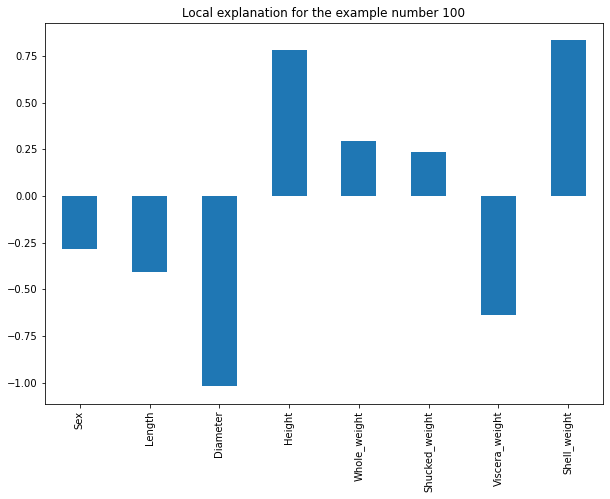

In [35]:
plt.figure(figsize=(10, 7))
selected_example = 100
print(f"Example number: {selected_example}")
print(f"\nFeature values -- Label: {train.iloc[selected_example]}")
local_explanations_out.iloc[selected_example][baseline.columns.tolist()].plot(kind='bar', title='Local explanation for the example number '+str(selected_example), rot=90)
plt.show()

Is the impact of the feature positive or negative with regards to the target variable

In [36]:
local_explanations_out['max_predictor_column'] = local_explanations_out[baseline.columns.tolist()].abs().idxmax(axis=1)
local_explanations_out['max_predictor_column_shap_value'] = local_explanations_out.apply(lambda x: np.sign(x[x['max_predictor_column']]), axis=1)

In [37]:
local_explanations_out[['max_predictor_column', 'max_predictor_column_shap_value']].value_counts()

max_predictor_column  max_predictor_column_shap_value
Shell_weight           1.0                               631
Shucked_weight         1.0                               604
Shell_weight          -1.0                               596
Shucked_weight        -1.0                               595
Diameter              -1.0                               124
Whole_weight          -1.0                                87
Height                 1.0                                63
Sex                   -1.0                                46
Whole_weight           1.0                                40
Viscera_weight        -1.0                                36
Height                -1.0                                36
Length                -1.0                                32
Viscera_weight         1.0                                11
Length                 1.0                                 8
Sex                    1.0                                 7
Diameter               1.0     